<a href="https://colab.research.google.com/github/pdwivedi1990/CaptchaCracker/blob/master/OCR_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!curl -LO https://github.com/pdwivedi1990/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   156  100   156    0     0    217      0 --:--:-- --:--:-- --:--:--   217
100 8863k  100 8863k    0     0  5729k      0  0:00:01  0:00:01 --:--:-- 27.0M


In [9]:
import os
from pathlib import Path

#get the image data
data_dir = Path("./captcha_images_v2/")

img = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in img]
characters_img = set(char for label in labels for char in label)

img_width = 200
img_height = 50

In [10]:
import numpy as np

# Shiffle and Split data into training and validation sets
def split_data(img, labels, train_size=0.9, shuffle=True):
    size = len(img)
    index = np.arange(size)
    if shuffle:
        np.random.shuffle(index)
    train_data = int(size * train_size)
    x_train, y_train = img[index[:train_data]], labels[index[:train_data]]
    x_valid, y_valid = img[index[train_data:]], labels[index[train_data:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(img), np.array(labels))

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters_img), num_oov_indices=0, mask_token=None
)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)
#Preprocessing step: Read, Resize and rescale the image, map the characters in labels to numbers
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)


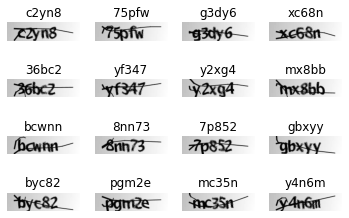

In [19]:
#Data Visualization
import matplotlib.pyplot as plt
_, ax = plt.subplots(4, 4)
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [20]:
from tensorflow import keras
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_len = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_len = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_len = input_len * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_len = label_len * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        self.add_loss(loss)
        return y_pred
        
def build_model():
    # Inputs to the model
    input_img = layers.Input( shape=(img_width, img_height, 1), dtype="float32")
    labels = layers.Input(shape=(None,), dtype="float32")

    # Convolutional layers, keeping Relu as activation function, stride of 3*3
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_img)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters_img) + 1, activation="softmax")(x)
    output = CTCLayer()(labels, x)
    model = keras.models.Model(inputs=[input_img, labels], outputs=output)
    
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    
    return model
model = build_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 50, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 100, 25, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 25, 64)  18496       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [22]:
validation_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_data = (
    validation_data.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [23]:
history = model.fit(train_dataset, validation_data=validation_data, epochs=50 )

Epoch 1/50
59/59 [==============================] - 3s 57ms/step - loss: 0.0681 - val_loss: 0.0064
Epoch 2/50
59/59 [==============================] - 2s 34ms/step - loss: 0.0545 - val_loss: 0.0055
Epoch 3/50
59/59 [==============================] - 2s 33ms/step - loss: 0.0712 - val_loss: 0.0467
Epoch 4/50
59/59 [==============================] - 2s 33ms/step - loss: 0.1223 - val_loss: 0.0076
Epoch 5/50
59/59 [==============================] - 2s 33ms/step - loss: 0.0792 - val_loss: 0.0048
Epoch 6/50
59/59 [==============================] - 2s 33ms/step - loss: 0.0392 - val_loss: 0.0046
Epoch 7/50
59/59 [==============================] - 2s 33ms/step - loss: 0.0554 - val_loss: 0.0192
Epoch 8/50
59/59 [==============================] - 2s 33ms/step - loss: 0.1058 - val_loss: 0.0088
Epoch 9/50
59/59 [==============================] - 2s 33ms/step - loss: 0.1019 - val_loss: 0.0063
Epoch 10/50
59/59 [==============================] - 2s 33ms/step - loss: 0.0802 - val_loss: 0.0748
Epoch 11/